## dataload

In [6]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename

SEED=67
## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'after_fe_train_test_bigcategory_fe.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1845310, 39), (1845310, 1), (1993, 39), (1993, 1))

In [7]:
df[:3]

userID assessmentItemID      testId  answerCode            Timestamp  \
0       0       A060001001  A060000001           1  2020-03-24 00:17:11   
1       0       A060001002  A060000001           1  2020-03-24 00:17:14   
2       0       A060001003  A060000001           1  2020-03-24 00:17:22   

   KnowledgeTag   kind  uidIdx  assIdx  testIdx  ...  time_category  \
0          7224  train       0    5354      975  ...              0   
1          7225  train       0    5355      975  ...              1   
2          7225  train       0    5356      975  ...              3   

   solvesec_cumsum  solvecumsum_category  big_category_acc  big_category_std  \
0              0.0                     0          0.711898          0.453371   
1              3.0                     1          0.711898          0.453371   
2             11.0                     4          0.711898          0.453371   

   big_category_cumconut  big_category_user_acc  big_category_user_std  \
0                      0               0.791908               0.406531   
1                      1               0.791908               0.406531   
2                      2               0.791908               0.406531   

   big_category_answer  big_category_answer_log1p  
0                  NaN                        NaN  
1                  1.0                   0.693147  
2                  2.0                   1.098612  

[3 rows x 40 columns]

## Hyper Parameter 설정

In [8]:
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
#     "learning_rate": 0.01,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

##  big_category 정답률, std, cumcount 추가

In [8]:
x_train.columns

Index(['userID', 'assessmentItemID', 'testId', 'Timestamp', 'KnowledgeTag',
       'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname',
       'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std',
       'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime',
       'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum',
       'solvecumsum_category', 'big_category_acc', 'big_category_std',
       'big_category_cumconut', 'big_category_user_acc',
       'big_category_user_std', 'big_category_answer',
       'big_category_answer_log1p'],
      dtype='object')

In [10]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_acc',
         'big_category_std',
         'big_category_cumconut'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM big_category 정답률, std, cumcount Seed 67] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model3 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=200,
    )

    preds3 = model3.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds3 >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds3)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model3_run_id=run.info.run_id
    post_slack("done")
    print(f"{model3_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model3, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/02 Fri)[LGBM big_category 정답률, std, cumcount Seed 67] 피처: 27개',
 '사용된 피처(27)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_acc, big_category_std, big_category_cumconut')

[LightGBM] [Info] Number of positive: 1205517, number of negative: 639793
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19286
[LightGBM] [Info] Number of data points in the train set: 1845310, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.653287 -> initscore=0.633519
[LightGBM] [Info] Start training from score 0.633519
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.564448
[200]	valid_0's binary_logloss: 0.558042
[300]	valid_0's binary_logloss: 0.55505
[400]	valid_0's binary_logloss: 0.554781
[500]	valid_0's binary_logloss: 0.553327
[600]	valid_0's binary_logloss: 0.552968
[700]	valid_0's binary_logloss: 0.553046
[800]	valid_0's binary_logloss: 0.55333
Early stopping, best iteration is:
[645]	valid_

In [13]:
### 제출 mlflow 등록
# 제출시
LB_AUC=
run_id = model3_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 6a42312b2c7044a8b69dc362a392f4c8


## big category 유저별 정답률, std, cumcount

In [11]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM big category 유저별 정답률, std, cumcount - Seed 67] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model4 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=200,
    )

    preds4 = model4.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds4 >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds4)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model4_run_id=run.info.run_id
    post_slack("done")
    print(f"{model4_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model4, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/02 Fri)[LGBM big category 유저별 정답률, std, cumcount - Seed 67] 피처: 27개',
 '사용된 피처(27)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_user_acc, big_category_user_std, big_category_cumconut')

[LightGBM] [Info] Number of positive: 1205517, number of negative: 639793
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19776
[LightGBM] [Info] Number of data points in the train set: 1845310, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.653287 -> initscore=0.633519
[LightGBM] [Info] Start training from score 0.633519
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.520546
[200]	valid_0's binary_logloss: 0.512273
[300]	valid_0's binary_logloss: 0.510471
[400]	valid_0's binary_logloss: 0.509543
[500]	valid_0's binary_logloss: 0.509502
[600]	valid_0's binary_logloss: 0.509864
Early stopping, best iteration is:
[435]	valid_0's binary_logloss: 0.508952
VALID AUC : 0.8278530215608868 ACC : 0.748118414450

In [25]:
### 제출 mlflow 등록
# 제출시
LB_AUC=
run_id = model4_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 3af96264ab7544119d567b2ad3ec4921


## val set을 test set으로

In [12]:
train = df[df.kind=='train']
test = df[df.kind=='test'] # 테스트 데이터
test_df = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
valid = test_df[test_df.userID != test_df.userID.shift(-1)]

train.shape, valid.shape, test.shape

x_train2 = train.drop('answerCode',axis=1)
y_train2 = train[['answerCode']]

x_valid2 = valid.drop('answerCode',axis=1)
y_valid2 = valid[['answerCode']]
x_train2.shape, y_train2.shape, x_valid2.shape, y_valid2.shape

((2266586, 40), (744, 40), (260114, 40))

((2266586, 39), (2266586, 1), (744, 39), (744, 1))

### 기존 big_category 정답률, std, cumcount

In [13]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_acc',
         'big_category_std',
         'big_category_cumconut'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM big_category 기존 - val set을 test 유저로] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train2[FEATS], y_train2)
lgb_x_valid = lgb.Dataset(x_valid2[FEATS], y_valid2)

with mlflow.start_run(run_name=title, description=desc) as run:
    model51 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=200,
    )

    preds51 = model51.predict(x_valid2[FEATS])
    acc = accuracy_score(y_valid2, np.where(preds51 >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid2, preds51)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model51_run_id=run.info.run_id
    post_slack("done")
    print(f"{model51_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model51, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/02 Fri)[LGBM big_category 기존 - val set을 test 유저로] 피처: 27개',
 '사용된 피처(27)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_acc, big_category_std, big_category_cumconut')

[LightGBM] [Info] Number of positive: 1483205, number of negative: 783381
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20332
[LightGBM] [Info] Number of data points in the train set: 2266586, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654378 -> initscore=0.638341
[LightGBM] [Info] Start training from score 0.638341
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.52183
[200]	valid_0's binary_logloss: 0.513773
[300]	valid_0's binary_logloss: 0.51159
[400]	valid_0's binary_logloss: 0.510402
[500]	valid_0's binary_logloss: 0.509858
[600]	valid_0's binary_logloss: 0.507916
[700]	valid_0's binary_logloss: 0.506312
[800]	valid_0's binary_logloss: 0.505696
[900]	valid_0's binary_logloss: 0.505515
[1000]

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=
run_id = model52_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

### big_category 유저별 정답률, std, cumcount

In [14]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM big_category 유저별 - val set을 test 유저로] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train2[FEATS], y_train2)
lgb_x_valid = lgb.Dataset(x_valid2[FEATS], y_valid2)

with mlflow.start_run(run_name=title, description=desc) as run:
    model52 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=200,
    )

    preds52 = model52.predict(x_valid2[FEATS])
    acc = accuracy_score(y_valid2, np.where(preds52 >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid2, preds52)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model52_run_id=run.info.run_id
    post_slack("done")
    print(f"{model52_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model52, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/02 Fri)[LGBM big_category 유저별 - val set을 test 유저로] 피처: 27개',
 '사용된 피처(27)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_user_acc, big_category_user_std, big_category_cumconut')

[LightGBM] [Info] Number of positive: 1483205, number of negative: 783381
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20822
[LightGBM] [Info] Number of data points in the train set: 2266586, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654378 -> initscore=0.638341
[LightGBM] [Info] Start training from score 0.638341
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.489573
[200]	valid_0's binary_logloss: 0.483277
[300]	valid_0's binary_logloss: 0.481121
[400]	valid_0's binary_logloss: 0.480713
[500]	valid_0's binary_logloss: 0.48097
[600]	valid_0's binary_logloss: 0.479647
[700]	valid_0's binary_logloss: 0.479147
[800]	valid_0's binary_logloss: 0.47962
Early stopping, best iteration is:
[679]	valid_

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=
run_id = model52_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## Feature Importance & Weights

In [16]:
import eli5
import shap

In [33]:
eli5.show_weights(model3)

In [35]:
import eli5
eli5.show_weights(model52)

In [53]:
# 예측을 높이는 기능은 빨간색으로 표시되고 예측을 낮추는 기능은 파란색으로 표시
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model52)
shap_values = explainer(x_train2[FEATS])

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [79]:
shap.initjs()
valid_explainer = shap.TreeExplainer(model52)
valid_shap_values = valid_explainer.shap_values(x_valid2[FEATS])
shap.force_plot(valid_explainer.expected_value[1], valid_shap_values[1][0,:], x_valid[FEATS].columns)

In [78]:
import shap
shap.initjs()
valid_explainer = shap.TreeExplainer(model52)
valid_shap_values = valid_explainer.shap_values(x_valid2[FEATS])
shap.force_plot(valid_explainer.expected_value[1], valid_shap_values[1][:,:], x_valid[FEATS].iloc[:,:])

In [80]:
shap.initjs()
test_explainer = shap.TreeExplainer(model52)
test_shap_values = test_explainer.shap_values(test[test.userID != test.userID.shift(-1)][FEATS])
shap.force_plot(test_explainer.expected_value[1], test_shap_values[1][:,:],  test[FEATS].iloc[:,:])

In [69]:
test_explainer.expected_value

[-0.9418833189740928, 0.9418833189740928]

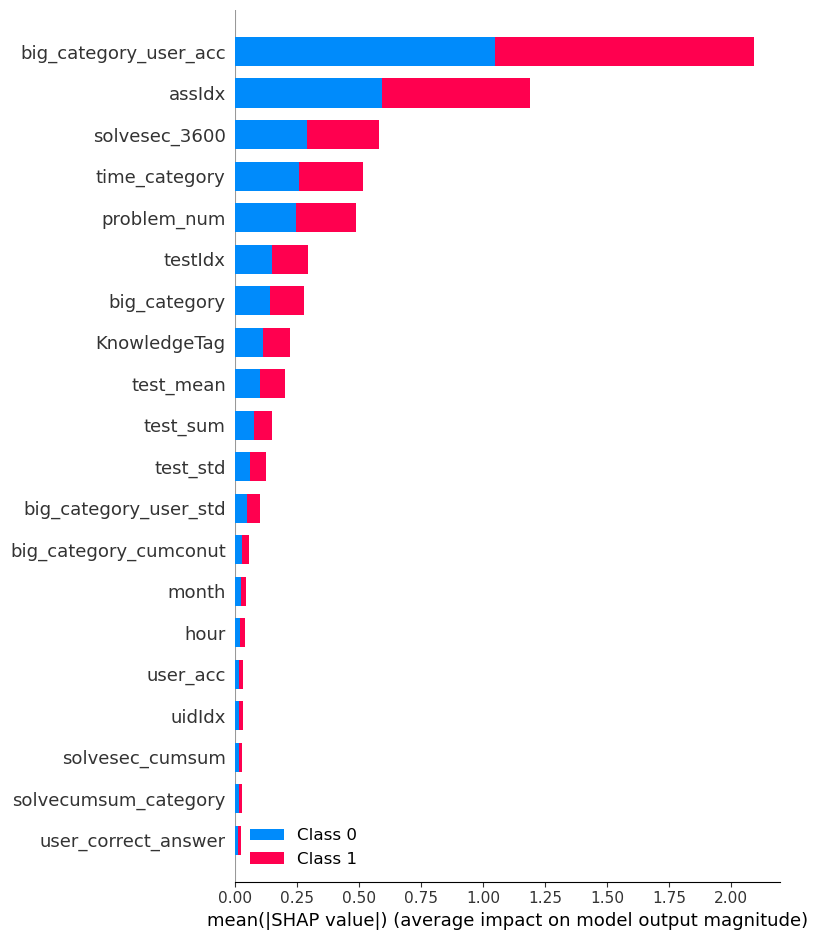

In [42]:
shap.initjs()
test_explainer = shap.TreeExplainer(model52)
test_shap_values = test_explainer.shap_values(test[test.userID != test.userID.shift(-1)][FEATS])
shap.summary_plot(test_shap_values, test[test.userID != test.userID.shift(-1)][FEATS])

In [ ]:
valid_shap_values

In [ ]:
train_shap_values = shap.TreeExplainer(model52).shap_values(x_train2[FEATS])

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])

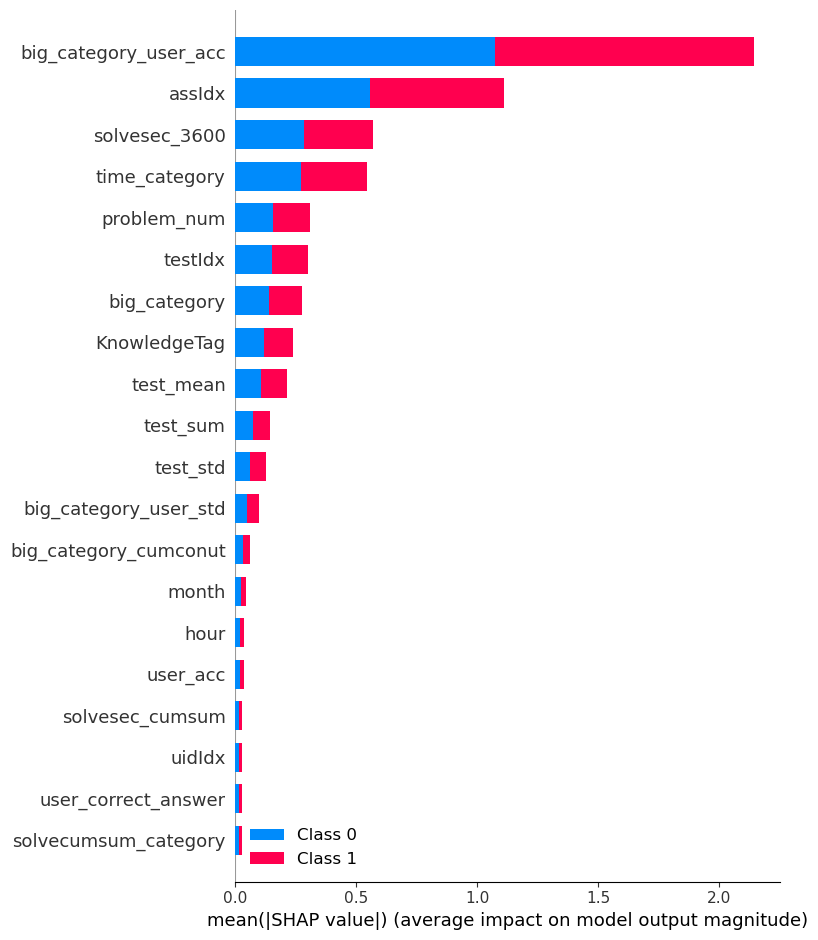

In [81]:
shap.summary_plot(shap_values, x_valid2[FEATS])

In [ ]:
shap.dependence_plot("big_category_user_acc", shap_values, x_valid2[FEATS])

In [42]:
perm = PermutationImportance(model52, scoring="roc_auc", n_iter=5, random_state=42)

### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut'
        ]
perm.fit(x_valid2[FEATS],y_valid2)

eli5.show_weights(perm)

## big_category_answer_log1p 추가

In [23]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut',
         'big_category_answer_log1p'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM big_category_answer_log1p 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model7 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=200,
    )

    preds = model7.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model7_run_id=run.info.run_id
    post_slack("done")
    print(f"{model7_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model7, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/01 Thu)[LGBM big_category_answer_log1p 추가] 피처: 28개',
 '사용된 피처(28)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_user_acc, big_category_user_std, big_category_cumconut, big_category_answer_log1p')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20061
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.512626
[200]	valid_0's binary_logloss: 0.503799
[300]	valid_0's binary_logloss: 0.500915
[400]	valid_0's binary_logloss: 0.500644
[500]	valid_0's binary_logloss: 0.500709
[600]	valid_0's binary_logloss: 0.500692
[700]	valid_0's binary_logloss: 0.501092
Early stopping, best iteration is:
[545]	valid_0's binary_logloss: 0.500358
VALID AUC 

In [26]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8062
run_id = model7_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 9673ba65009845779aed5d57850755e3


### big_category_answer_log1p 추가 3200 epoch

In [28]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut',
         'big_category_answer_log1p'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM big_category_answer_log1p 추가 3200epoch] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model71 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
#         early_stopping_rounds=200,
    )

    preds = model71.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model71_run_id=run.info.run_id
    post_slack("done")
    print(f"{model71_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model71, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/01 Thu)[LGBM big_category_answer_log1p 추가 3200epoch] 피처: 28개',
 '사용된 피처(28)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_user_acc, big_category_user_std, big_category_cumconut, big_category_answer_log1p')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20061
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
[100]	valid_0's binary_logloss: 0.512626
[200]	valid_0's binary_logloss: 0.503799
[300]	valid_0's binary_logloss: 0.500915
[400]	valid_0's binary_logloss: 0.500644
[500]	valid_0's binary_logloss: 0.500709
[600]	valid_0's binary_logloss: 0.500692
[700]	valid_0's binary_logloss: 0.501092
[800]	valid_0's binary_logloss: 0.501289
[900]	valid_0's binary_logloss: 0.501496
[1000]	valid_0's binary_logloss: 0.502544
[1100]	valid_0's binary_

In [29]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7948
run_id = model71_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 254fd0dba60b46cf84742c32cc677bb4


## big_category_answer log1p 안한것

In [24]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut',
         'big_category_answer'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM big_category_answer log1p 안한것] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model8 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=200,
    )

    preds = model8.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model8_run_id=run.info.run_id
    post_slack("done")
    print(f"{model8_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model8, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/01 Thu)[LGBM big_category_answer log1p 안한것] 피처: 28개',
 '사용된 피처(28)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_user_acc, big_category_user_std, big_category_cumconut, big_category_answer')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20061
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.512626
[200]	valid_0's binary_logloss: 0.503799
[300]	valid_0's binary_logloss: 0.500915
[400]	valid_0's binary_logloss: 0.500644
[500]	valid_0's binary_logloss: 0.500709
[600]	valid_0's binary_logloss: 0.500692
[700]	valid_0's binary_logloss: 0.501092
Early stopping, best iteration is:
[545]	valid_0's binary_logloss: 0.500358
VALID AUC 

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8112
run_id = model8_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## Validation Set Align

In [31]:
# model1
FEATS1 = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_acc',
         'big_category_std',
         'big_category_cumconut'
        ]

# model2
FEATS2 = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_acc',
         'big_category_std',
         'big_category_cumconut'
        ]

# model5
FEATS5 = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
        ]
# model6
FEATS6 = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut'
        ]

# model7
FEATS7 = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut',
         'big_category_answer_log1p'
        ]

# model71
FEATS71 = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut',
         'big_category_answer_log1p'
        ]

In [53]:
def model2auc(model, x_valid, y_valid, FEATS):
    preds = model.predict(x_valid[FEATS])
    auc = roc_auc_score(y_valid, preds)
    return auc

In [34]:
from collections import defaultdict

model_dict = defaultdict(list)

for n in [1,2,5,6,7,71]:
    model_dict[f"model{n}"].append(eval(f'model{n}'))
    model_dict[f"model{n}"].append(eval(f'FEATS{n}'))

In [40]:
model_dict.keys()

dict_keys(['model1', 'model2', 'model5', 'model6', 'model7', 'model71'])

## seed별 학습 및 auc 비교

In [ ]:
model2 # 0.8155 - big_category 정답률, std, cumcount 추가 early stop
model6 # 0.8024 - big_category 유저별 정답률, std, cumcount 추가 early stop
model71 # 0.7948 - big_category_answer_log1p 추가 early stop

In [69]:
def model_train2auc(run_title, x_valid, y_valid, FEATS, seed, experiment_id):
    lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
    lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)
    with mlflow.start_run(run_name=run_title, experiment_id=experiment_id) as run:
        model = lgb.train(
            params, 
            lgb_x_train,
            valid_sets=[lgb_x_valid],
            verbose_eval=-1,
            num_boost_round=3200,
            categorical_feature=cat_feats_idx,
            early_stopping_rounds=200,
        )
        preds = model.predict(x_valid[FEATS])
        auc = roc_auc_score(y_valid, preds)
        mlflow.log_metric("VAL AUC",auc)
        mlflow.log_metric("VAL Set SEED",seed)
    return model, auc

In [ ]:
from mlflow.tracking import MlflowClient
client = MlflowClient()
experiment_name = "Validation Set Align2"
experiment_id = client.create_experiment(experiment_name)

In [65]:
experiment_id

'312762763748397651'

In [ ]:
mlflow.lightgbm.autolog()
for s in range(100):
    print(f"----------------------------- SEED {s} -----------------------------")
    train, valid = custom_train_test_split(train_df, ratio=0.7, seed=s) # 훈련데이터 split
    test = df[df.kind=='test'] # 테스트 데이터
    train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
    train = pd.concat([train,train2]) # 훈련데이터 병합
    x_train = train.drop('answerCode',axis=1)
    y_train = train[['answerCode']]
    x_valid = valid.drop('answerCode',axis=1)
    y_valid = valid[['answerCode']]
    x_train.shape, y_train.shape, x_valid.shape, y_valid.shape
    aucs=[]
    for n,lb in zip([2,6,71],[0.8155,0.8024,0.7948]):
        model_name = f"model{n}"
        run_title = f"model{n} - LB AUC:{lb}"
        model,feats = model_dict[model_name]
        model, auc = model_train2auc(run_title, x_valid, y_valid, feats, s, experiment_id)
        print(f"{model_name} Val Auc: {auc:.3f}")
        model_dict[model_name][0] = model
        aucs.append(auc)
    saucs = sorted(aucs)
    sort_index = [saucs.index(i) for i in aucs]
    print(sort_index)
    if sort_index==[3,4,1,2,0]:
        print(s)
        post_slack("done")
        break

### seed별 auc 확인

In [52]:
for s in range(100):
    train, valid = custom_train_test_split(train_df, ratio=0.7, seed=s) # 훈련데이터 split
    test = df[df.kind=='test'] # 테스트 데이터
    train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
    train = pd.concat([train,train2]) # 훈련데이터 병합
    x_train = train.drop('answerCode',axis=1)
    y_train = train[['answerCode']]
    x_valid = valid.drop('answerCode',axis=1)
    y_valid = valid[['answerCode']]
    x_train.shape, y_train.shape, x_valid.shape, y_valid.shape
    aucs=[]
    for n in [1,2,6,7,71]:
        model_name = f"model{n}"
        model,feats = model_dict[model_name]
        auc = model2auc(model, x_valid, y_valid, feats)
        print(f"{model_name} {auc:.3f}",end=' ')
        aucs.append(auc)
    saucs = sorted(aucs)
    sort_index = [saucs.index(i) for i in aucs]
    print(sort_index)
    if sort_index==[3,4,1,2,0]:
        print(s)
        post_slack("done")
        break

((1845739, 39), (1845739, 1), (1968, 39), (1968, 1))

model1 0.888 model2 0.856 model6 0.867 model7 0.870 model71 0.905 [3, 0, 1, 2, 4]


((1845952, 39), (1845952, 1), (2015, 39), (2015, 1))

model1 0.896 model2 0.864 model6 0.871 model7 0.876 model71 0.912 [3, 0, 1, 2, 4]


((1845977, 39), (1845977, 1), (2011, 39), (2011, 1))

model1 0.882 model2 0.849 model6 0.859 model7 0.864 model71 0.903 [3, 0, 1, 2, 4]


((1845528, 39), (1845528, 1), (2009, 39), (2009, 1))

model1 0.899 model2 0.865 model6 0.872 model7 0.877 model71 0.913 [3, 0, 1, 2, 4]


((1845319, 39), (1845319, 1), (2016, 39), (2016, 1))

model1 0.887 model2 0.856 model6 0.861 model7 0.868 model71 0.907 [3, 0, 1, 2, 4]


((1845636, 39), (1845636, 1), (1977, 39), (1977, 1))

model1 0.881 model2 0.845 model6 0.864 model7 0.868 model71 0.907 [3, 0, 1, 2, 4]


((1845842, 39), (1845842, 1), (1992, 39), (1992, 1))

model1 0.890 model2 0.857 model6 0.870 model7 0.874 model71 0.910 [3, 0, 1, 2, 4]


((1845872, 39), (1845872, 1), (1951, 39), (1951, 1))

model1 0.889 model2 0.856 model6 0.868 model7 0.873 model71 0.909 [3, 0, 1, 2, 4]


((1845720, 39), (1845720, 1), (2000, 39), (2000, 1))

model1 0.878 model2 0.849 model6 0.862 model7 0.866 model71 0.904 [3, 0, 1, 2, 4]


((1845915, 39), (1845915, 1), (1940, 39), (1940, 1))

model1 0.894 model2 0.857 model6 0.866 model7 0.870 model71 0.911 [3, 0, 1, 2, 4]


((1845869, 39), (1845869, 1), (2036, 39), (2036, 1))

model1 0.884 model2 0.855 model6 0.865 model7 0.870 model71 0.906 [3, 0, 1, 2, 4]


((1845919, 39), (1845919, 1), (2006, 39), (2006, 1))

model1 0.894 model2 0.860 model6 0.865 model7 0.869 model71 0.907 [3, 0, 1, 2, 4]


((1845257, 39), (1845257, 1), (2031, 39), (2031, 1))

model1 0.883 model2 0.849 model6 0.864 model7 0.868 model71 0.907 [3, 0, 1, 2, 4]


((1845539, 39), (1845539, 1), (1974, 39), (1974, 1))

model1 0.791 model2 0.797 model6 0.834 model7 0.834 model71 0.832 [0, 1, 3, 4, 2]


((1845583, 39), (1845583, 1), (1991, 39), (1991, 1))

model1 0.888 model2 0.855 model6 0.867 model7 0.872 model71 0.910 [3, 0, 1, 2, 4]


((1845753, 39), (1845753, 1), (1975, 39), (1975, 1))

model1 0.888 model2 0.851 model6 0.864 model7 0.870 model71 0.908 [3, 0, 1, 2, 4]


((1845890, 39), (1845890, 1), (1966, 39), (1966, 1))

model1 0.889 model2 0.852 model6 0.863 model7 0.868 model71 0.907 [3, 0, 1, 2, 4]


((1845409, 39), (1845409, 1), (1992, 39), (1992, 1))

model1 0.886 model2 0.857 model6 0.863 model7 0.867 model71 0.901 [3, 0, 1, 2, 4]


((1845711, 39), (1845711, 1), (2035, 39), (2035, 1))

model1 0.884 model2 0.852 model6 0.864 model7 0.869 model71 0.906 [3, 0, 1, 2, 4]


((1845937, 39), (1845937, 1), (2032, 39), (2032, 1))

model1 0.897 model2 0.862 model6 0.872 model7 0.877 model71 0.913 [3, 0, 1, 2, 4]


((1845954, 39), (1845954, 1), (1983, 39), (1983, 1))

model1 0.882 model2 0.844 model6 0.858 model7 0.863 model71 0.903 [3, 0, 1, 2, 4]


((1845674, 39), (1845674, 1), (2027, 39), (2027, 1))

model1 0.889 model2 0.855 model6 0.869 model7 0.873 model71 0.908 [3, 0, 1, 2, 4]


((1845820, 39), (1845820, 1), (1981, 39), (1981, 1))

model1 0.883 model2 0.846 model6 0.859 model7 0.864 model71 0.903 [3, 0, 1, 2, 4]


((1845978, 39), (1845978, 1), (1970, 39), (1970, 1))

model1 0.892 model2 0.863 model6 0.877 model7 0.881 model71 0.914 [3, 0, 1, 2, 4]


((1845901, 39), (1845901, 1), (2044, 39), (2044, 1))

model1 0.894 model2 0.860 model6 0.869 model7 0.874 model71 0.912 [3, 0, 1, 2, 4]


((1845312, 39), (1845312, 1), (1966, 39), (1966, 1))

model1 0.889 model2 0.856 model6 0.868 model7 0.875 model71 0.913 [3, 0, 1, 2, 4]


((1844865, 39), (1844865, 1), (2069, 39), (2069, 1))

model1 0.894 model2 0.858 model6 0.870 model7 0.875 model71 0.914 [3, 0, 1, 2, 4]


((1845900, 39), (1845900, 1), (2019, 39), (2019, 1))

model1 0.887 model2 0.855 model6 0.865 model7 0.869 model71 0.904 [3, 0, 1, 2, 4]


((1845851, 39), (1845851, 1), (2003, 39), (2003, 1))

model1 0.887 model2 0.851 model6 0.865 model7 0.870 model71 0.910 [3, 0, 1, 2, 4]


((1845822, 39), (1845822, 1), (2007, 39), (2007, 1))

model1 0.887 model2 0.848 model6 0.858 model7 0.863 model71 0.903 [3, 0, 1, 2, 4]


((1845891, 39), (1845891, 1), (1996, 39), (1996, 1))

model1 0.883 model2 0.847 model6 0.858 model7 0.863 model71 0.903 [3, 0, 1, 2, 4]


((1845542, 39), (1845542, 1), (1987, 39), (1987, 1))

model1 0.904 model2 0.867 model6 0.862 model7 0.869 model71 0.909 [3, 1, 0, 2, 4]


((1845146, 39), (1845146, 1), (1920, 39), (1920, 1))

model1 0.898 model2 0.866 model6 0.875 model7 0.879 model71 0.914 [3, 0, 1, 2, 4]


((1845805, 39), (1845805, 1), (2007, 39), (2007, 1))

model1 0.896 model2 0.864 model6 0.871 model7 0.875 model71 0.910 [3, 0, 1, 2, 4]


((1845771, 39), (1845771, 1), (2020, 39), (2020, 1))

model1 0.890 model2 0.857 model6 0.868 model7 0.873 model71 0.908 [3, 0, 1, 2, 4]


((1845977, 39), (1845977, 1), (1947, 39), (1947, 1))

model1 0.877 model2 0.846 model6 0.858 model7 0.863 model71 0.899 [3, 0, 1, 2, 4]


((1845739, 39), (1845739, 1), (2013, 39), (2013, 1))

model1 0.884 model2 0.849 model6 0.862 model7 0.867 model71 0.906 [3, 0, 1, 2, 4]


((1845868, 39), (1845868, 1), (1990, 39), (1990, 1))

model1 0.886 model2 0.850 model6 0.863 model7 0.870 model71 0.908 [3, 0, 1, 2, 4]


((1845887, 39), (1845887, 1), (2043, 39), (2043, 1))

model1 0.893 model2 0.855 model6 0.869 model7 0.874 model71 0.912 [3, 0, 1, 2, 4]


((1845699, 39), (1845699, 1), (1977, 39), (1977, 1))

model1 0.892 model2 0.856 model6 0.867 model7 0.873 model71 0.915 [3, 0, 1, 2, 4]


((1845922, 39), (1845922, 1), (2042, 39), (2042, 1))

model1 0.896 model2 0.863 model6 0.877 model7 0.881 model71 0.913 [3, 0, 1, 2, 4]


((1845652, 39), (1845652, 1), (2037, 39), (2037, 1))

model1 0.879 model2 0.844 model6 0.856 model7 0.862 model71 0.902 [3, 0, 1, 2, 4]


((1845527, 39), (1845527, 1), (2007, 39), (2007, 1))

model1 0.887 model2 0.854 model6 0.864 model7 0.868 model71 0.903 [3, 0, 1, 2, 4]


((1845922, 39), (1845922, 1), (1993, 39), (1993, 1))

model1 0.887 model2 0.850 model6 0.860 model7 0.866 model71 0.909 [3, 0, 1, 2, 4]


((1845794, 39), (1845794, 1), (1961, 39), (1961, 1))

model1 0.895 model2 0.864 model6 0.876 model7 0.880 model71 0.911 [3, 0, 1, 2, 4]


((1845500, 39), (1845500, 1), (2016, 39), (2016, 1))

model1 0.894 model2 0.857 model6 0.866 model7 0.872 model71 0.913 [3, 0, 1, 2, 4]


((1845974, 39), (1845974, 1), (1944, 39), (1944, 1))

model1 0.879 model2 0.840 model6 0.852 model7 0.858 model71 0.900 [3, 0, 1, 2, 4]


((1845521, 39), (1845521, 1), (2060, 39), (2060, 1))

model1 0.884 model2 0.849 model6 0.863 model7 0.868 model71 0.908 [3, 0, 1, 2, 4]


((1845500, 39), (1845500, 1), (1995, 39), (1995, 1))

model1 0.888 model2 0.855 model6 0.864 model7 0.869 model71 0.909 [3, 0, 1, 2, 4]


((1845797, 39), (1845797, 1), (2000, 39), (2000, 1))

model1 0.891 model2 0.857 model6 0.866 model7 0.871 model71 0.908 [3, 0, 1, 2, 4]


((1845470, 39), (1845470, 1), (2073, 39), (2073, 1))

model1 0.892 model2 0.856 model6 0.866 model7 0.870 model71 0.911 [3, 0, 1, 2, 4]


((1845514, 39), (1845514, 1), (1955, 39), (1955, 1))

model1 0.898 model2 0.863 model6 0.870 model7 0.875 model71 0.912 [3, 0, 1, 2, 4]


((1845303, 39), (1845303, 1), (1996, 39), (1996, 1))

model1 0.895 model2 0.864 model6 0.876 model7 0.881 model71 0.920 [3, 0, 1, 2, 4]


((1845978, 39), (1845978, 1), (2058, 39), (2058, 1))

model1 0.886 model2 0.852 model6 0.866 model7 0.871 model71 0.910 [3, 0, 1, 2, 4]


((1845753, 39), (1845753, 1), (2076, 39), (2076, 1))

model1 0.879 model2 0.843 model6 0.854 model7 0.859 model71 0.900 [3, 0, 1, 2, 4]


((1845855, 39), (1845855, 1), (2033, 39), (2033, 1))

model1 0.885 model2 0.849 model6 0.861 model7 0.867 model71 0.905 [3, 0, 1, 2, 4]


((1845418, 39), (1845418, 1), (2015, 39), (2015, 1))

model1 0.886 model2 0.856 model6 0.870 model7 0.874 model71 0.910 [3, 0, 1, 2, 4]


((1845562, 39), (1845562, 1), (1972, 39), (1972, 1))

model1 0.883 model2 0.849 model6 0.867 model7 0.872 model71 0.907 [3, 0, 1, 2, 4]


((1845929, 39), (1845929, 1), (2079, 39), (2079, 1))

model1 0.898 model2 0.862 model6 0.865 model7 0.870 model71 0.912 [3, 0, 1, 2, 4]


((1845923, 39), (1845923, 1), (1994, 39), (1994, 1))

model1 0.895 model2 0.861 model6 0.863 model7 0.869 model71 0.909 [3, 0, 1, 2, 4]


((1844831, 39), (1844831, 1), (2036, 39), (2036, 1))

model1 0.892 model2 0.855 model6 0.859 model7 0.864 model71 0.905 [3, 0, 1, 2, 4]


((1845846, 39), (1845846, 1), (1945, 39), (1945, 1))

model1 0.894 model2 0.860 model6 0.863 model7 0.867 model71 0.907 [3, 0, 1, 2, 4]


((1845429, 39), (1845429, 1), (1987, 39), (1987, 1))

model1 0.885 model2 0.846 model6 0.859 model7 0.864 model71 0.901 [3, 0, 1, 2, 4]


((1845700, 39), (1845700, 1), (1990, 39), (1990, 1))

model1 0.884 model2 0.851 model6 0.855 model7 0.862 model71 0.901 [3, 0, 1, 2, 4]


((1845876, 39), (1845876, 1), (2050, 39), (2050, 1))

model1 0.887 model2 0.855 model6 0.871 model7 0.875 model71 0.913 [3, 0, 1, 2, 4]


((1845728, 39), (1845728, 1), (2011, 39), (2011, 1))

model1 0.884 model2 0.850 model6 0.860 model7 0.865 model71 0.904 [3, 0, 1, 2, 4]


((1845940, 39), (1845940, 1), (2092, 39), (2092, 1))

model1 0.888 model2 0.855 model6 0.865 model7 0.870 model71 0.906 [3, 0, 1, 2, 4]


((1845310, 39), (1845310, 1), (1993, 39), (1993, 1))

model1 0.877 model2 0.839 model6 0.852 model7 0.858 model71 0.896 [3, 0, 1, 2, 4]


((1845740, 39), (1845740, 1), (1990, 39), (1990, 1))

model1 0.886 model2 0.848 model6 0.857 model7 0.863 model71 0.905 [3, 0, 1, 2, 4]


((1845969, 39), (1845969, 1), (2048, 39), (2048, 1))

model1 0.891 model2 0.859 model6 0.867 model7 0.872 model71 0.909 [3, 0, 1, 2, 4]


((1845893, 39), (1845893, 1), (1995, 39), (1995, 1))

model1 0.898 model2 0.863 model6 0.868 model7 0.875 model71 0.917 [3, 0, 1, 2, 4]


((1845789, 39), (1845789, 1), (2031, 39), (2031, 1))

model1 0.899 model2 0.863 model6 0.871 model7 0.876 model71 0.915 [3, 0, 1, 2, 4]


((1845679, 39), (1845679, 1), (2020, 39), (2020, 1))

model1 0.887 model2 0.852 model6 0.866 model7 0.871 model71 0.910 [3, 0, 1, 2, 4]


((1845678, 39), (1845678, 1), (2035, 39), (2035, 1))

model1 0.887 model2 0.846 model6 0.856 model7 0.861 model71 0.907 [3, 0, 1, 2, 4]


((1845704, 39), (1845704, 1), (2072, 39), (2072, 1))

model1 0.884 model2 0.853 model6 0.862 model7 0.867 model71 0.906 [3, 0, 1, 2, 4]


((1845956, 39), (1845956, 1), (1989, 39), (1989, 1))

model1 0.880 model2 0.844 model6 0.850 model7 0.854 model71 0.895 [3, 0, 1, 2, 4]


((1845524, 39), (1845524, 1), (2022, 39), (2022, 1))

model1 0.892 model2 0.860 model6 0.867 model7 0.872 model71 0.910 [3, 0, 1, 2, 4]


((1845930, 39), (1845930, 1), (1988, 39), (1988, 1))

model1 0.889 model2 0.856 model6 0.866 model7 0.870 model71 0.908 [3, 0, 1, 2, 4]


((1845521, 39), (1845521, 1), (2014, 39), (2014, 1))

model1 0.903 model2 0.870 model6 0.879 model7 0.883 model71 0.919 [3, 0, 1, 2, 4]


((1845719, 39), (1845719, 1), (2020, 39), (2020, 1))

model1 0.877 model2 0.839 model6 0.853 model7 0.858 model71 0.900 [3, 0, 1, 2, 4]


((1845813, 39), (1845813, 1), (2013, 39), (2013, 1))

model1 0.890 model2 0.856 model6 0.870 model7 0.875 model71 0.912 [3, 0, 1, 2, 4]


((1845888, 39), (1845888, 1), (1998, 39), (1998, 1))

model1 0.878 model2 0.845 model6 0.859 model7 0.864 model71 0.902 [3, 0, 1, 2, 4]


((1845517, 39), (1845517, 1), (2028, 39), (2028, 1))

model1 0.890 model2 0.861 model6 0.871 model7 0.877 model71 0.912 [3, 0, 1, 2, 4]


((1845847, 39), (1845847, 1), (2078, 39), (2078, 1))

model1 0.891 model2 0.856 model6 0.874 model7 0.879 model71 0.916 [3, 0, 1, 2, 4]


((1844623, 39), (1844623, 1), (1985, 39), (1985, 1))

model1 0.881 model2 0.848 model6 0.864 model7 0.868 model71 0.904 [3, 0, 1, 2, 4]


((1845839, 39), (1845839, 1), (2040, 39), (2040, 1))

model1 0.891 model2 0.858 model6 0.861 model7 0.865 model71 0.905 [3, 0, 1, 2, 4]


((1845739, 39), (1845739, 1), (2031, 39), (2031, 1))

model1 0.898 model2 0.860 model6 0.871 model7 0.877 model71 0.918 [3, 0, 1, 2, 4]


((1845638, 39), (1845638, 1), (1980, 39), (1980, 1))

model1 0.892 model2 0.862 model6 0.877 model7 0.881 model71 0.915 [3, 0, 1, 2, 4]


((1845590, 39), (1845590, 1), (2008, 39), (2008, 1))

model1 0.881 model2 0.844 model6 0.863 model7 0.869 model71 0.909 [3, 0, 1, 2, 4]


((1845848, 39), (1845848, 1), (1966, 39), (1966, 1))

model1 0.892 model2 0.861 model6 0.867 model7 0.873 model71 0.912 [3, 0, 1, 2, 4]


((1845900, 39), (1845900, 1), (1987, 39), (1987, 1))

model1 0.881 model2 0.848 model6 0.860 model7 0.864 model71 0.908 [3, 0, 1, 2, 4]


((1845587, 39), (1845587, 1), (2062, 39), (2062, 1))

model1 0.890 model2 0.852 model6 0.866 model7 0.871 model71 0.912 [3, 0, 1, 2, 4]


((1845809, 39), (1845809, 1), (2043, 39), (2043, 1))

model1 0.891 model2 0.856 model6 0.864 model7 0.869 model71 0.905 [3, 0, 1, 2, 4]


((1845524, 39), (1845524, 1), (1943, 39), (1943, 1))

model1 0.879 model2 0.843 model6 0.849 model7 0.854 model71 0.895 [3, 0, 1, 2, 4]


((1845408, 39), (1845408, 1), (2047, 39), (2047, 1))

model1 0.884 model2 0.848 model6 0.860 model7 0.865 model71 0.907 [3, 0, 1, 2, 4]


((1845774, 39), (1845774, 1), (2031, 39), (2031, 1))

model1 0.879 model2 0.844 model6 0.860 model7 0.865 model71 0.904 [3, 0, 1, 2, 4]


((1845491, 39), (1845491, 1), (2040, 39), (2040, 1))

model1 0.894 model2 0.861 model6 0.870 model7 0.875 model71 0.909 [3, 0, 1, 2, 4]


((1845808, 39), (1845808, 1), (2110, 39), (2110, 1))

model1 0.897 model2 0.860 model6 0.868 model7 0.874 model71 0.918 [3, 0, 1, 2, 4]


((1845858, 39), (1845858, 1), (2014, 39), (2014, 1))

model1 0.893 model2 0.863 model6 0.870 model7 0.876 model71 0.910 [3, 0, 1, 2, 4]


((1845722, 39), (1845722, 1), (1980, 39), (1980, 1))

model1 0.887 model2 0.848 model6 0.856 model7 0.860 model71 0.901 [3, 0, 1, 2, 4]


In [48]:
saucs = sorted(aucs)

In [50]:
[saucs.index(i) for i in aucs]==[3,4,1,2,0]

False

In [ ]:
model2 # 0.8155
model6 # 0.8024 
model71 # 0.7948

In [ ]:
model1 # 0.8111 3
model2 # 0.8155 4
model5 # 0.8112
model6 # 0.8024 1
model7 # 0.8062 2
model71 # 0.7948 0